# Lending Tree Loan Status
## Classification: Catboost GPU
### Hyperopt HPO: 300 Trials 3-fold Cross Validation

## Set Up Environment & Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install eli5
!pip install lime
import os
import random
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from timeit import default_timer as timer
import time
import ast
import pickle
import joblib
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import webbrowser
from eli5.formatters import format_as_dataframe
from lime import lime_tabular
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 29 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 62.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d5f35002b64399caef48a71f626a7c6b63758ab48516ceba017e21a139807740
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requi

In [ ]:
# Set seed
seed_value = 42
os.environ['cat_GPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# Upsampling

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = pd.read_csv('trainDF_US.csv', low_memory=False)
testDF = pd.read_csv('testDF_US.csv', low_memory=False)

# Set up train/test split
X_train = trainDF.drop('loan_status', axis=1)
y_train = trainDF.loan_status
X_test = testDF.drop('loan_status', axis=1)
y_test = testDF.loan_status

## Baseline Model

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL


In [ ]:
# Define model
cat = CatBoostClassifier(loss_function='Logloss',
                         eval_metric='Accuracy',
                         task_type='GPU',
                         rsm=1,
                         random_state=seed_value,
                         logging_level='Silent')

# Fit model
cat.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_US_Baseline.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(cat, file)

# Predict based on training
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)

print('\nModel Metrics for Catboost Baseline Upsampling')
print('Training Set')
print('Classification Report:')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_train, y_train_pred))
print('Precision score : %.3f' % precision_score(y_train, y_train_pred))
print('Recall score : %.3f' % recall_score(y_train, y_train_pred))
print('F1 score : %.3f' % f1_score(y_train, y_train_pred))

print('\n')
print('Test Set')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test, y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Catboost Baseline Upsampling
Training Set
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96   1511066
           1       0.99      0.92      0.96   1511066

    accuracy                           0.96   3022132
   macro avg       0.96      0.96      0.96   3022132
weighted avg       0.96      0.96      0.96   3022132



Confusion matrix:
[[1497132   13934]
 [ 117003 1394063]]


Accuracy score : 0.957
Precision score : 0.990
Recall score : 0.923
F1 score : 0.955


Test Set
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    377848
           1       0.93      0.92      0.93     54625

    accuracy                           0.98    432473
   macro avg       0.96      0.96      0.96    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[374250   3598]
 [  4162  50463]]


Accuracy score : 0.982
Pr

## 300 Trials 3-fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# Define parameter grid
cat_tune_kwargs= {
    'iterations': hp.choice('iterations', np.arange(100, 500, dtype=int)),
    'depth': hp.choice('depth', np.arange(3, 10, dtype=int)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1e-2, 1e0),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(2, 20,
                                                                dtype=int)),
    'one_hot_max_size': hp.choice('one_hot_max_size', np.arange(2, 20,
                                                                dtype=int)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
    }

In [ ]:
# Define a function for optimization of hyperparameters
def cat_hpo(config):

    """
    Objective function to tune a `CatoostClassifier` model.
    """

    joblib.dump(bayesOpt_trials, 'Catboost_Hyperopt_300_GPU_Upsampling.pkl')

    # Keep track of evaluations
    global ITERATION

    ITERATION += 1

    # Parameters that are integers to remain integers
    config['iterations'] = int(config['iterations'])

    # Start hyperopt at 3 for max_depth
    config['depth'] = int(config['depth']) + 3

    # Define model type
    cat = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Accuracy',
                             task_type='GPU',
                             early_stopping_rounds=1000,
                             rsm=1,
                             random_state=seed_value,
                             logging_level='Silent',
                             **config)

    # Start timer for each trial
    start = timer()

    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(cat, X_train, y_train,
                              scoring='roc_auc', cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    best_score = np.max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])

    return {'loss': loss, 'params': config, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'Catboost_HPO_Upsampling_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials
# Start timer for experiment
search_time_start = time.time()
if os.path.isfile('Catboost_Hyperopt_300_GPU_Upsampling.pkl'):
  bayesOpt_trials = joblib.load('Catboost_Hyperopt_300_GPU_Upsampling.pkl')
else:
  best_param = fmin(cat_hpo, cat_tune_kwargs, algo=tpe.suggest,
                    max_evals=NUM_EVAL, trials=bayesOpt_trials,
                    rstate= np.random.RandomState(42))
# End timer for experiment
print('Time to run HPO:', time.time() - search_time_start)

100%|██████████| 300/300 [3:57:26<00:00, 47.49s/it, best loss: 1.9573690667239017]
Time to run HPO: 14246.234592199326


In [ ]:
# Sort the trials with lowest loss (highest AUC)
bayesOpt_trials_results = sorted(bayesOpt_trials.results,
                                       key=lambda x: x['loss'])
print('Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_trials_results[:2])

Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9573690667239017, 'params': {'depth': 6, 'iterations': 209, 'l2_leaf_reg': 0.3258948761851098, 'learning_rate': 0.00013510336684909182, 'min_data_in_leaf': 2, 'one_hot_max_size': 2, 'scale_pos_weight': 0.40174760984637287}, 'iteration': 146, 'train_time': 25.390702735998275, 'status': 'ok'}, {'loss': 1.9588298628994352, 'params': {'depth': 6, 'iterations': 116, 'l2_leaf_reg': 0.2438578789209958, 'learning_rate': 0.0003641712068393032, 'min_data_in_leaf': 9, 'one_hot_max_size': 2, 'scale_pos_weight': 0.4537388406626548}, 'iteration': 151, 'train_time': 17.52426112899957, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('Catboost_HPO_Upsampling_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.to_csv('Catboost_HPO_Upsampling_300.csv', index=False)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = CatBoostClassifier(loss_function='Logloss',
                                      eval_metric='Accuracy',
                                      task_type='GPU',
                                      early_stopping_rounds=1000,
                                      rsm=1,
                                      random_state=seed_value,
                                      logging_level='Silent',
                                      **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Upsampling_300trials_GPU.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Upsampling_300trials_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Catboost HPO Upsampling 300 GPU trials')
# Predict based on training
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)
print('\n')
print('Metrics: Train Set')
print('Classification Report:')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_train, y_train_pred))
print('Precision score : %.3f' % precision_score(y_train, y_train_pred))
print('Recall score : %.3f' % recall_score(y_train, y_train_pred))
print('F1 score : %.3f' % f1_score(y_train, y_train_pred))
print('\n')
print('Metrics: Test Set')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Catboost HPO Upsampling 300 GPU trials


Metrics: Train Set
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91   1511066
           1       0.99      0.81      0.89   1511066

    accuracy                           0.90   3022132
   macro avg       0.91      0.90      0.90   3022132
weighted avg       0.91      0.90      0.90   3022132



Confusion matrix:
[[1493331   17735]
 [ 284981 1226085]]


Accuracy score : 0.900
Precision score : 0.986
Recall score : 0.811
F1 score : 0.890


Metrics: Test Set
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    377848
           1       0.91      0.81      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.94      0.90      0.92    432473
weighted avg       0.96      0.97      0.97    432473



Confusion matrix:
[[373405   4443]
 [ 10319  44306]]


In [ ]:
# Evaluate predictive probability on the testing data
preds = best_bayes_model.predict_proba(X_test)[:, 1]
print('The best model from Upsampling Bayes 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test,
                                                                                                                                     preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 300 GPU trials optimization scores 0.95791 AUC ROC on the test set.
This was achieved after 146 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Catboost_HPO_Upsampling_300_GPU.csv',
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['depth'] = bayes_params['depth'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['l2_leaf_reg'] = bayes_params['l2_leaf_reg'].astype('float64')
bayes_params['min_data_in_leaf'] = bayes_params['min_data_in_leaf'].astype('float64')
bayes_params['one_hot_max_size'] = bayes_params['one_hot_max_size'].astype('float64')

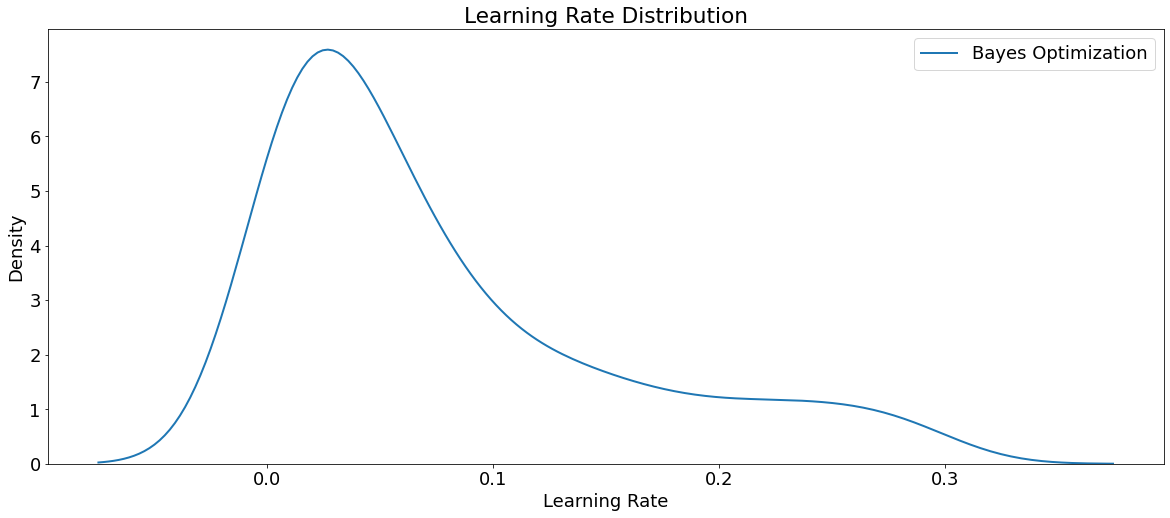

In [ ]:
# Density plots of the learning rate distributions
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization',
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

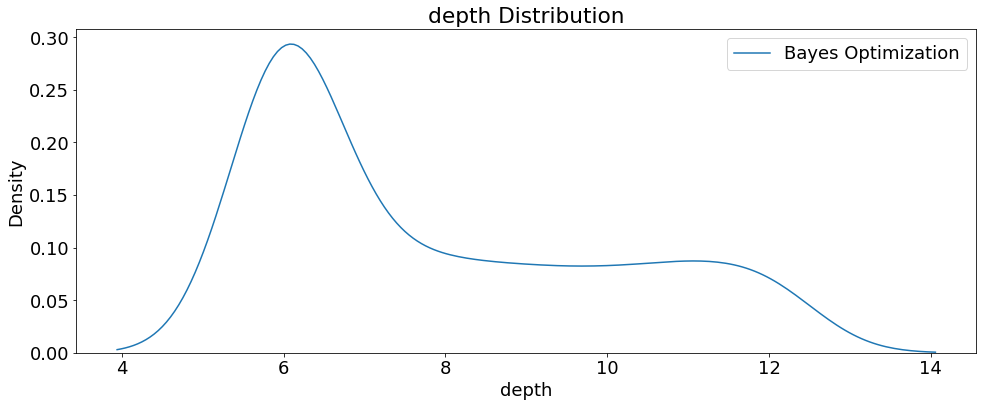

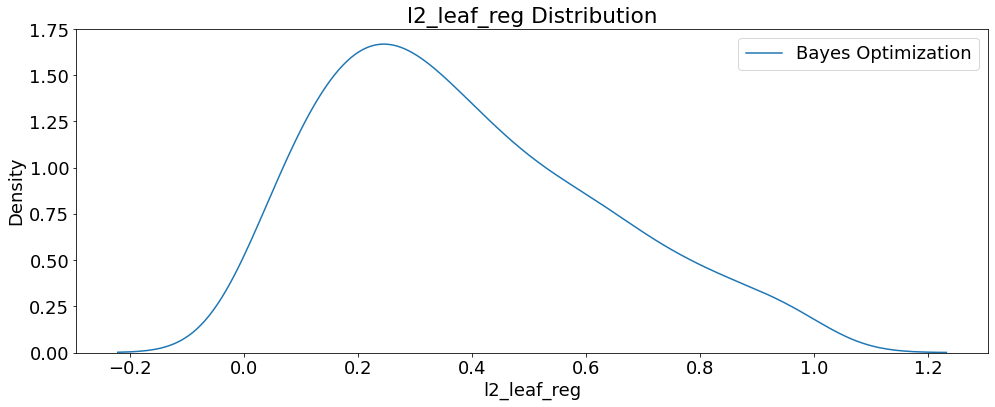

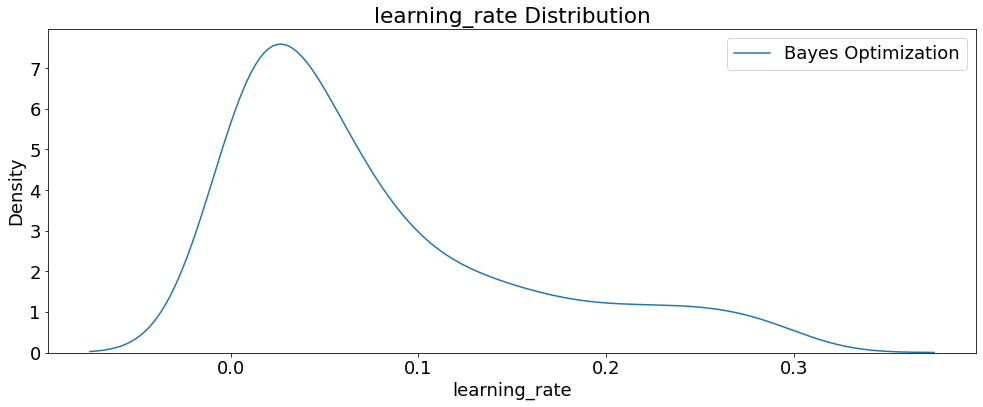

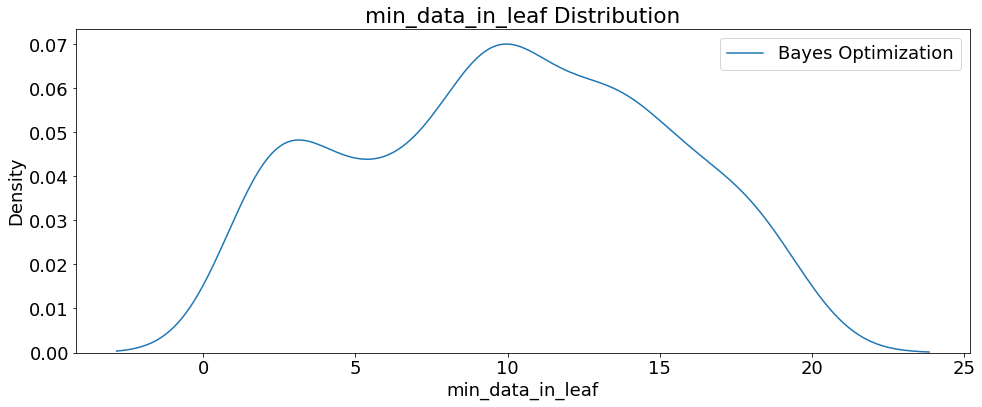

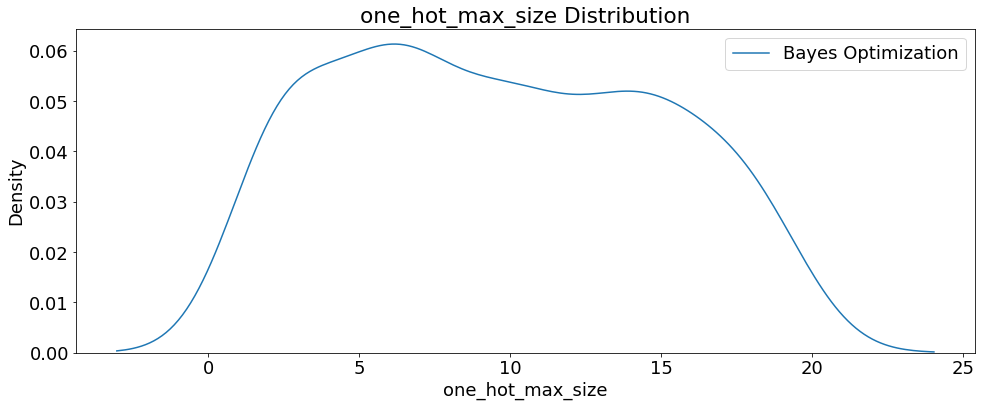

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'scale_pos_weight', 'iterations']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

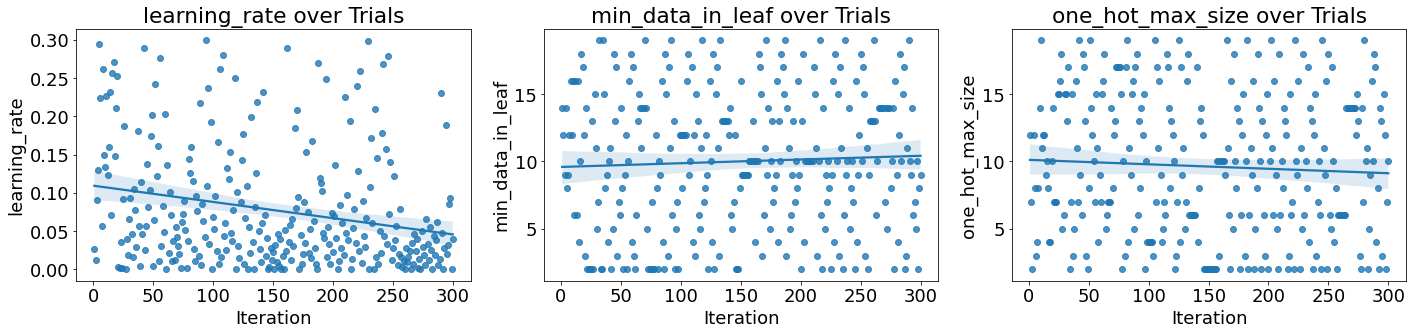

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf',
                         'one_hot_max_size']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

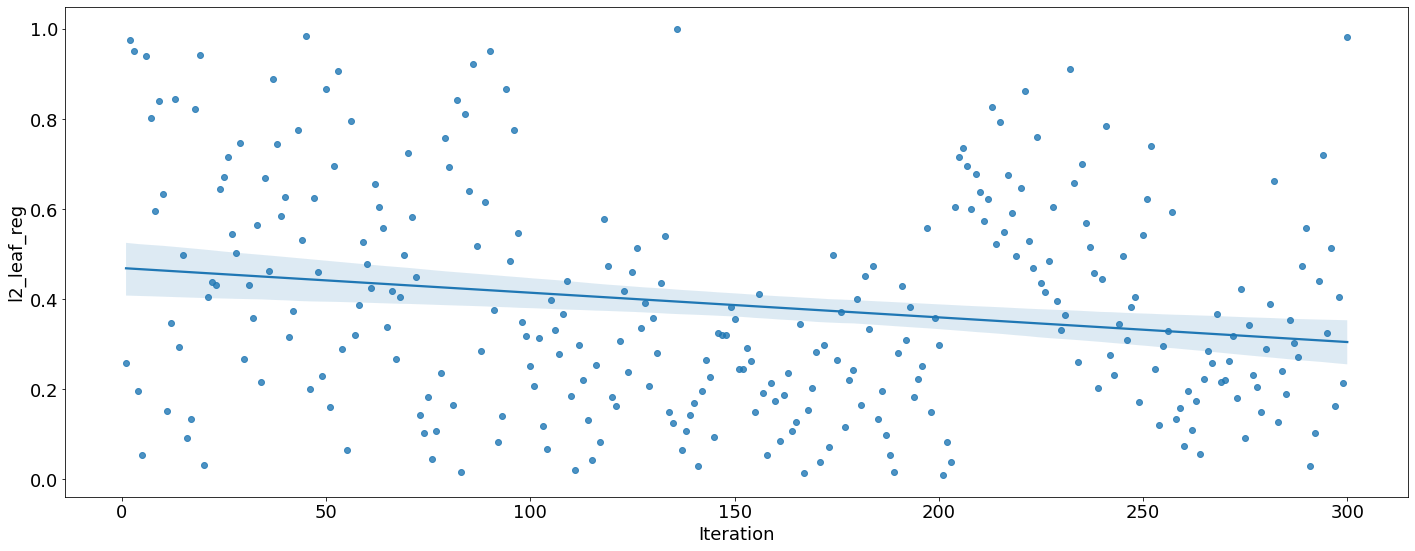

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize =(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=bayes_params,
                 label='Bayes Optimization')
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_300_GPU_WeightsExplain.csv', index=False)
exp

feature    weight       std
0                    out_prncp  0.191393  0.000222
1                  total_pymnt  0.066605  0.000278
2              last_pymnt_amnt  0.063684  0.000252
3                   recoveries  0.059626  0.000150
4              term_ 60 months  0.030153  0.000194
5                  installment  0.021211  0.000150
6                 num_tl_30dpd  0.000000  0.000000
7                     num_sats  0.000000  0.000000
8                    num_bc_tl  0.000000  0.000000
9                  num_bc_sats  0.000000  0.000000
10              inq_last_6mths  0.000000  0.000000
11                 delinq_amnt  0.000000  0.000000
12    chargeoff_within_12_mths  0.000000  0.000000
13              bc_open_to_buy  0.000000  0.000000
14                    int_rate  0.000000  0.000000
15                   tax_liens  0.000000  0.000000
16                  annual_inc  0.000000  0.000000
17  collections_12_mths_ex_med  0.000000  0.000000
18        mths_since_recent_bc  0.000000  0.000000
19          num_tl_op_past_12m  0.000000  0.000000

In [ ]:
# LIME for model explanations
X_train1 = pd.DataFrame(X_train, columns=trainDF.columns)

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train1.columns,
    class_names=['current', 'default'],
    mode='classification')

exp = explainer.explain_instance(
    data_row=X_train.iloc[1],
    predict_fn=best_bayes_model.predict_proba)
exp.save_to_file('best_bayes_Upsampling_300_GPU_LIME_Train.html')
exp.show_in_notebook()

In [ ]:
# LIME for model explanations
X_test1 = pd.DataFrame(X_test, columns=testDF.columns)

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_test),
    feature_names=X_test1.columns,
    class_names=['current', 'default'],
    mode='classification')

exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=best_bayes_model.predict_proba)
exp.save_to_file('best_bayes_Upsampling_300_GPU_LIME_Test.html')
exp.show_in_notebook()

# SMOTE

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = pd.read_csv('trainDF_SMOTE.csv', low_memory=False)
testDF = pd.read_csv('testDF_SMOTE.csv', low_memory=False)

In [ ]:
# Set up train/test split
X_train = trainDF.drop('loan_status', axis=1)
y_train = trainDF.loan_status
X_test = testDF.drop('loan_status', axis=1)
y_test = testDF.loan_status

## Baseline Model

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL


In [ ]:
# Define model
cat = CatBoostClassifier(loss_function='Logloss',
                         eval_metric='Accuracy',
                         task_type='GPU',
                         rsm=1,
                         random_state=seed_value,
                         logging_level='Silent')

# Fit the model
cat.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_SMOTE_Baseline.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(cat, file)

# Predict based on training
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)

print('\nModel Metrics for Catboost Baseline SMOTE')
print('Training Set')
print('Classification Report:')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_train, y_train_pred))
print('Precision score : %.3f' % precision_score(y_train, y_train_pred))
print('Recall score : %.3f' % recall_score(y_train, y_train_pred))
print('F1 score : %.3f' % f1_score(y_train, y_train_pred))

print('\n')
print('Test Set')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test, y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Catboost Baseline SMOTE
Training Set
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1511066
           1       1.00      0.98      0.99   1511066

    accuracy                           0.99   3022132
   macro avg       0.99      0.99      0.99   3022132
weighted avg       0.99      0.99      0.99   3022132



Confusion matrix:
[[1510812     254]
 [  25828 1485238]]


Accuracy score : 0.991
Precision score : 1.000
Recall score : 0.983
F1 score : 0.991


Test Set
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       1.00      0.89      0.94     54625

    accuracy                           0.99    432473
   macro avg       0.99      0.94      0.97    432473
weighted avg       0.99      0.99      0.99    432473



Confusion matrix:
[[377756     92]
 [  6121  48504]]


Accuracy score : 0.986
Precisi

## 300 Trials 3-fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/trialOptions/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/trialOptions


In [ ]:
# Define a function for optimization of hyperparameters
def cat_hpo(config):

    """
    Objective function to tune a `CatoostClassifier` model.
    """

    joblib.dump(bayesOpt_trials, 'Catboost_Hyperopt_300_GPU_SMOTE.pkl')

    # Keep track of evaluations
    global ITERATION

    ITERATION += 1

    # Parameters that are integers to remain integers
    config['iterations'] = int(config['iterations'])

    # Start hyperopt at 3 for max_depth
    config['depth'] = int(config['depth']) + 3

    # Define model type
    cat = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Accuracy',
                             task_type='GPU',
                             early_stopping_rounds=1000,
                             rsm=1,
                             random_state=seed_value,
                             logging_level='Silent',
                             **config)

    # Start timer for each trial
    start = timer()

    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(cat, X_train, y_train,
                              scoring='roc_auc', cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    best_score = np.max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])

    return {'loss': loss, 'params': config, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# File to save first results
out_file = 'Catboost_HPO_SMOTE_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials
# Start timer for experiment
search_time_start = time.time()
if os.path.isfile('Catboost_Hyperopt_300_GPU_SMOTE.pkl'):
  bayesOpt_trials = joblib.load('Catboost_Hyperopt_300_GPU_SMOTE.pkl')
else:
  best_param = fmin(cat_hpo, cat_tune_kwargs, algo=tpe.suggest,
                    max_evals=NUM_EVAL, trials=bayesOpt_trials,
                    rstate= np.random.RandomState(42))
# End timer for experiment
print('Time to run HPO:', time.time() - search_time_start)

100%|██████████| 300/300 [4:23:34<00:00, 52.71s/it, best loss: 1.986611148805046]
Time to run HPO: 15814.154031038284


In [ ]:
# Sort the trials with lowest loss (highest AUC)
bayesOpt_SMOTE_trials_results = sorted(bayesOpt_trials.results,
                                       key=lambda x: x['loss'])
print('SMOTE HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_SMOTE_trials_results[:2])

SMOTE HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.980194769, 'params': {{'depth': 6, 'iterations': 147, 'l2_leaf_reg': 0.45955410099353006, 'learning_rate': 0.00039618942851448347, 'min_data_in_leaf': 7, 'one_hot_max_size': 4, 'scale_pos_weight': 0.9988887521448616}}, {'loss': 1.985901093, 'params': {{'depth': 8, 'iterations': 151, 'l2_leaf_reg': 0.5173073169790545, 'learning_rate': 0.00027951478762068267, 'min_data_in_leaf': 12, 'one_hot_max_size': 11, 'scale_pos_weight': 0.7330968900751821}}]


In [ ]:
# Access results
results = pd.read_csv('Catboost_HPO_SMOTE_300.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.to_csv('Catboost_HPO_SMOTE_300.csv', index=False)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = CatBoostClassifier(loss_function='Logloss',
                                      eval_metric='Accuracy',
                                      task_type='GPU',
                                      early_stopping_rounds=1000,
                                      rsm=1,
                                      random_state=seed_value,
                                      logging_level='Silent',
                                      **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_SMOTE_300trials_GPU.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_SMOTE_300trials_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Catboost HPO SMOTE 300 GPU trials')
# Predict based on training
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)
print('\n')
print('Metrics: Train Set')
print('Classification Report:')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_train, y_train_pred))
print('Precision score : %.3f' % precision_score(y_train, y_train_pred))
print('Recall score : %.3f' % recall_score(y_train, y_train_pred))
print('F1 score : %.3f' % f1_score(y_train, y_train_pred))
print('\n')
print('Metrics: Test Set')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(y_test, y_test_pred))
print('Precision score : %.3f' % precision_score(y_test,y_test_pred))
print('Recall score : %.3f' % recall_score(y_test, y_test_pred))
print('F1 score : %.3f' % f1_score(y_test, y_test_pred))


Model Metrics for Catboost HPO SMOTE 300 GPU trials


Metrics: Train Set
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94   1511066
           1       0.97      0.91      0.94   1511066

    accuracy                           0.94   3022132
   macro avg       0.94      0.94      0.94   3022132
weighted avg       0.94      0.94      0.94   3022132



Confusion matrix:
[[1470993   40073]
 [ 135213 1375853]]


Accuracy score : 0.942
Precision score : 0.972
Recall score : 0.911
F1 score : 0.940


Metrics: Test Set
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    377848
           1       0.81      0.77      0.78     54625

    accuracy                           0.95    432473
   macro avg       0.89      0.87      0.88    432473
weighted avg       0.95      0.95      0.95    432473



Confusion matrix:
[[367739  10109]
 [ 12807  41818]]


Acc

In [ ]:
# Evaluate predictive probability on the testing data
preds = best_bayes_model.predict_proba(X_test)[:, 1]
print('The best model from SMOTE Bayes 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test,
                                                                                                                                preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from SMOTE Bayes 300 GPU trials optimization scores 0.95924 AUC ROC on the test set.
This was achieved after 299 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/bayesParams/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Catboost_HPO_SMOTE_300_GPU.csv', index=False)

In [ ]:
# Convert data types for graphing
bayes_params['depth'] = bayes_params['depth'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['l2_leaf_reg'] = bayes_params['l2_leaf_reg'].astype('float64')
bayes_params['min_data_in_leaf'] = bayes_params['min_data_in_leaf'].astype('float64')
bayes_params['one_hot_max_size'] = bayes_params['one_hot_max_size'].astype('float64')

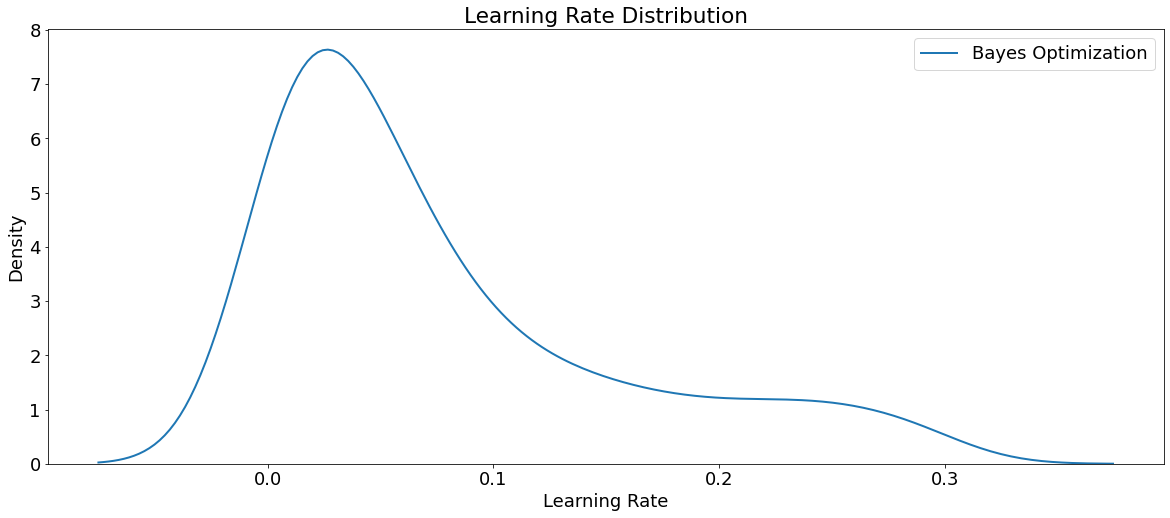

In [ ]:
# Density plots of the learning rate distributions
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization',
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

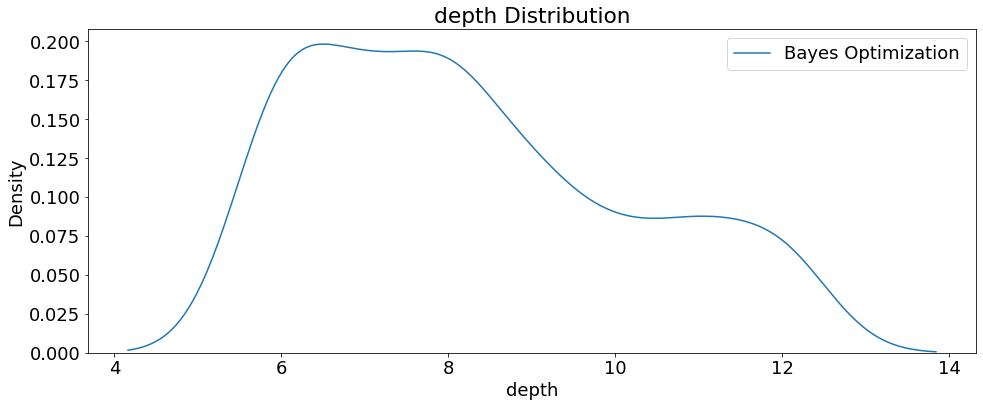

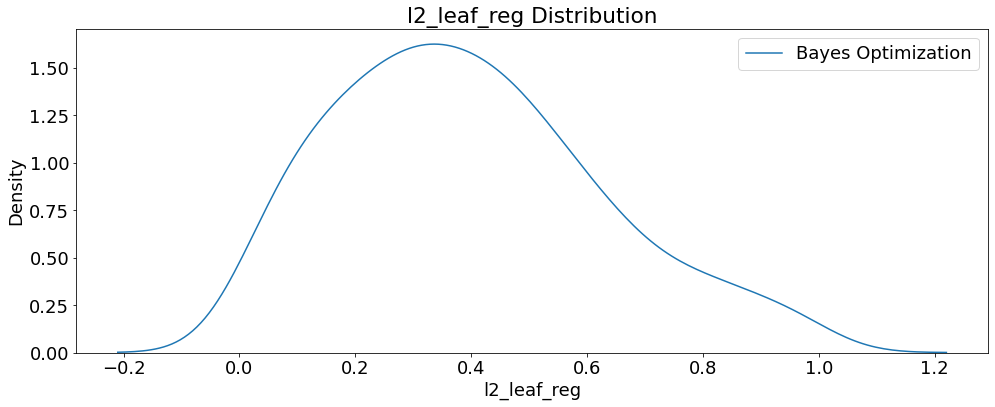

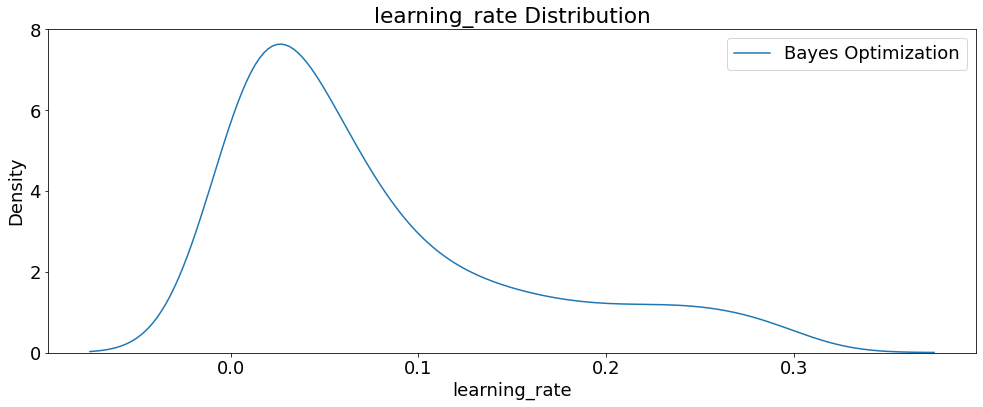

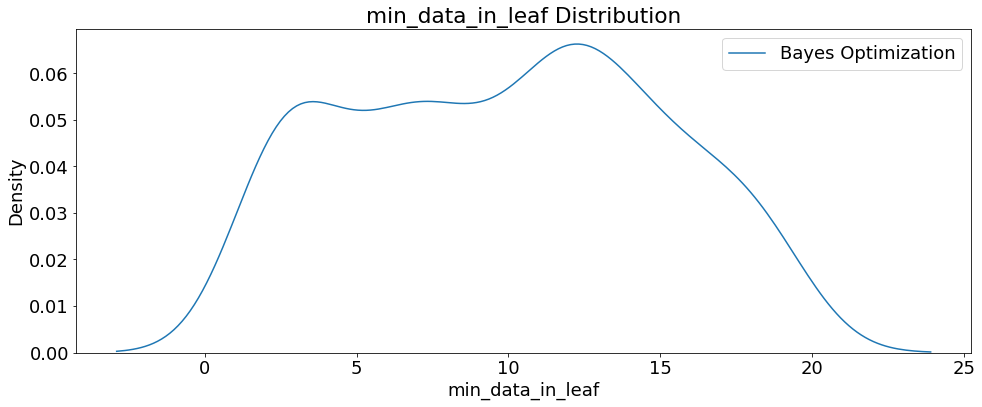

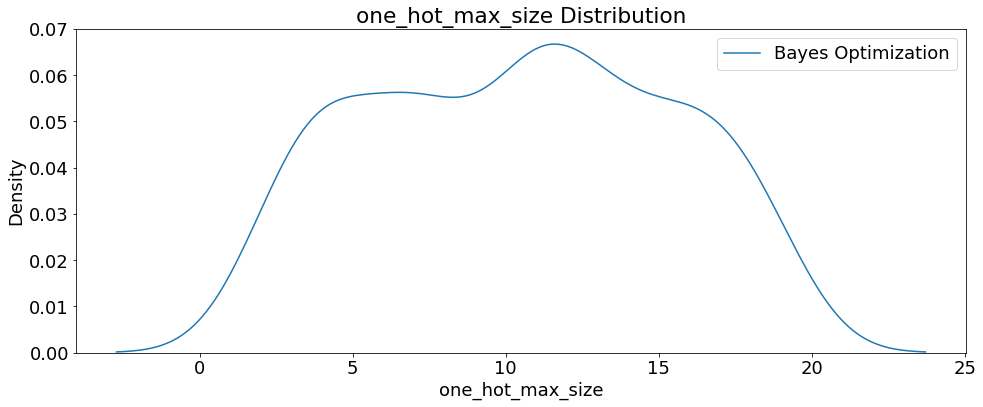

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'scale_pos_weight', 'iterations']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

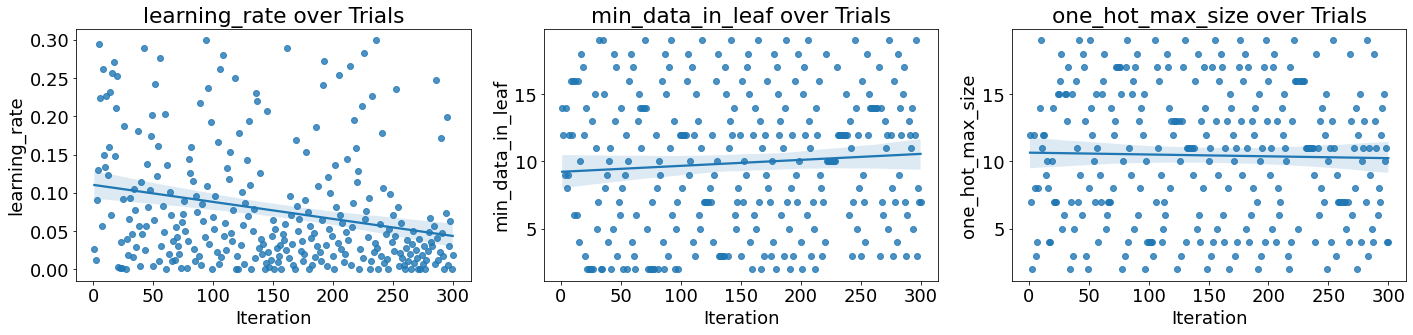

In [ ]:
# Plot quantitative hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf',
                         'one_hot_max_size']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

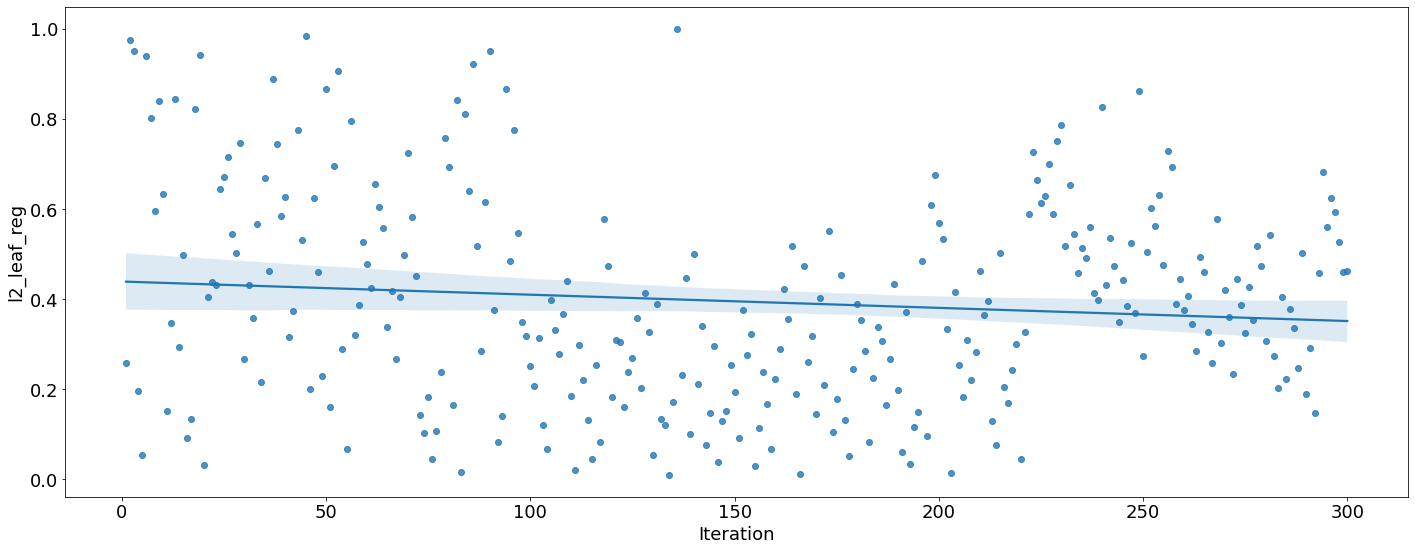

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize =(20,8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data=bayes_params,
                 label='Bayes Optimization')
ax.set(xlabel='Iteration', ylabel='l2_leaf_reg')
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/best_bayes_SMOTE_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Python/Models/ML/Catboost/Hyperopt/Model_Explanations/best_bayes_SMOTE_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_SMOTE_300_GPU_WeightsExplain.csv', index=False)
exp

feature    weight       std
0                   recoveries  0.099834  0.000141
1                    out_prncp  0.083224  0.000214
2              last_pymnt_amnt  0.059569  0.000222
3              term_ 60 months  0.034549  0.000323
4           total_rec_late_fee  0.010871  0.000125
5                  total_pymnt  0.000513  0.000019
6                 num_tl_30dpd  0.000000  0.000000
7                     num_sats  0.000000  0.000000
8                    num_bc_tl  0.000000  0.000000
9                  num_bc_sats  0.000000  0.000000
10        mths_since_recent_bc  0.000000  0.000000
11                  annual_inc  0.000000  0.000000
12    chargeoff_within_12_mths  0.000000  0.000000
13              bc_open_to_buy  0.000000  0.000000
14                    int_rate  0.000000  0.000000
15                   tax_liens  0.000000  0.000000
16                 installment  0.000000  0.000000
17  collections_12_mths_ex_med  0.000000  0.000000
18                 delinq_amnt  0.000000  0.000000
19          num_tl_op_past_12m  0.000000  0.000000

In [ ]:
# LIME for model explanations
X_train1 = pd.DataFrame(X_train, columns=trainDF.columns)

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train1.columns,
    class_names=['current', 'default'],
    mode='classification')

exp = explainer.explain_instance(
    data_row=X_train.iloc[1],
    predict_fn=best_bayes_model.predict_proba)
exp.save_to_file('best_bayes_SMOTE_300_GPU_LIME_Train.html')
exp.show_in_notebook()

In [ ]:
# LIME for model explanations
X_test1 = pd.DataFrame(X_test, columns=testDF.columns)

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_test),
    feature_names=X_test1.columns,
    class_names=['current', 'default'],
    mode='classification')

exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=best_bayes_model.predict_proba)
exp.save_to_file('best_bayes_SMOTE_300_GPU_LIME_Test.html')
exp.show_in_notebook()